## Import ##

In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from PIL import Image
import tqdm
import time
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, RandomHorizontalFlip, ToTensor, CenterCrop, RandomAdjustSharpness, RandomAutocontrast
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.manual_seed(150)
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Data ##

In [4]:
class MyData(Dataset):
    def __init__(self, path, size):
        self.path = path
        self.size = size
    
    def __len__(self):
        return len(os.listdir( self.path ))
    
    def __getitem__(self, idx):
        img = Image.open( os.path.join( self.path, os.listdir( self.path )[idx] ) )
        img = Compose([ToTensor(), 
                       CenterCrop(self.size), 
                       RandomHorizontalFlip(), 
                       RandomAdjustSharpness(1), 
                       RandomAutocontrast()])(img)
        return img

<div class="alert alert-block alert-success">
<b>Comment:</b> Dataset "dogs-vs-cats". 
    
Link: https://www.kaggle.com/c/dogs-vs-cats
</div>

In [3]:
pth = 'A:\\My files\\Datasets\\dogs-vs-cats\\train\\train'

In [485]:
mdata = MyData(pth, (256,256))

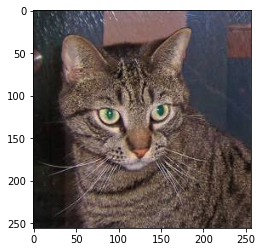

In [492]:
plt.imshow(mdata[1].permute(1,2,0)) # cat <3

In [6]:
My_loader = DataLoader(mdata, batch_size = 10)

## Neural Network ##

### Generator ###

In [7]:
class GANGenerator(nn.Module):
    def __init__(self, input_size, batch_size, lat_dimension, channels):
        super(GANGenerator, self).__init__()
        self.input_size = input_size // 4 # it is one number, not a tuple
        self.batch_size = batch_size
        self.lat_dimension = lat_dimension # generate from this dimension
        self.channels = channels
        
        self.lin = nn.Sequential( nn.Linear(self.lat_dimension, 128 * self.input_size ** 2), )
        self.bn1 = nn.BatchNorm2d(num_features = 128)
        self.up1 = nn.Upsample(scale_factor = 2)
        self.cn1 = nn.Conv2d(128, 128, 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(128, 0.8)
        self.rl1 = nn.LeakyReLU(0.2, inplace = True)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.cn2 = nn.Conv2d(128, 64, 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64, 0.8)
        self.rl2 = nn.LeakyReLU(0.2, inplace = True)
        self.cn3 = nn.Conv2d(64, self.channels, 3, stride = 1, padding = 1)
        self.act =  nn.Tanh()
    
    def forward(self, x):
        # self.input_size = 256 // 4 = 64
        x = self.lin(x) # (batch, 128 * 64 ** 2)
        x = x.view(x.shape[0], 128, self.input_size, self.input_size) # (batch, 128, 64, 64)
        x = self.bn1(x) 
        x = self.up1(x) # (batch, 128, 128, 128)
        x = self.cn1(x) # (batch, 128, 128, 128)
        x = self.bn2(x) 
        x = self.rl1(x) 
        x = self.up2(x) # (batch, 128, 256, 256)
        x = self.cn2(x) # (batch, 64, 256, 256)
        x = self.bn3(x) 
        x = self.rl2(x) 
        x = self.cn3(x) # (batch, self.channels, 256, 256)
        out = self.act(x) 
        return out

In [8]:
g = GANGenerator(input_size = 256, batch_size = 1, lat_dimension = 64, channels = 3)

What is generated?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


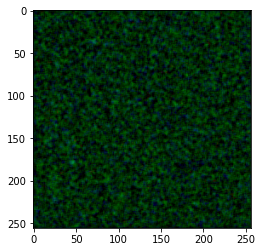

In [118]:
plt.imshow(np.transpose(g(torch.randn(1,64)).detach().numpy().reshape(3,256,256), (1,2,0)))

Noise

### Discriminator ###

In [8]:
class GANDiscriminator(nn.Module):
    def __init__(self, channels, image_size):
        super(GANDiscriminator, self).__init__()
        self.channels = channels
        self.image_size = image_size
        def disk_module(input_channels, output_channels, b_norm: bool = True):
            mod = [ nn.Conv2d(input_channels, output_channels, 3, 2, 1), nn.LeakyReLU(0.2, inplace = True), nn.Dropout2d(0.25) ]
            if (b_norm):
                mod += [ nn.BatchNorm2d(output_channels, 0.8) ]
            return mod
        
        self.disk_model = nn.Sequential(*disk_module(self.channels, 16, b_norm = False), 
                                        *disk_module(16, 32), 
                                        *disk_module(32, 64), 
                                        *disk_module(64, 128))
        
        down_size = self.image_size // 2 ** 4
        self.adverse_lyr = nn.Sequential( nn.Linear(128 * down_size ** 2, 1), nn.Sigmoid() )
    def forward(self, x):
        x = self.disk_model(x)
        x = x.view(x.shape[0], -1)
        out = self.adverse_lyr(x)
        return out

In [10]:
d = GANDiscriminator(3, 256)

In [130]:
d(next(iter(mdata)).reshape(1,3,256,256))

tensor([[0.5032]], grad_fn=<SigmoidBackward0>)

## Train - loop ##

### Train function ###

In [95]:
def train_model(model_generator, model_discriminator, 
                epochs, data_loader, 
                optimizer_generator, optimizer_discriminator, 
                loss, device,
                lat_dimension: int = 64, ):
    
    with tqdm.notebook.tqdm_notebook(range(epochs)) as tq_epoch:
        for epoch in tq_epoch:
            tq_epoch.set_description('Epoch = {}, initial time = {}'.format(epoch, 
                                                                            str(pd.Timestamp(time.time(), 
                                                                                             unit = 's', tz = 'Europe/Moscow').time())[:8]))
            with tqdm.notebook.tqdm_notebook(data_loader) as tq_loader:
                for X in tq_loader:
                    
                    # form batch of labels
                    good_img = torch.autograd.Variable( torch.FloatTensor(X.shape[0], 1).fill_(1.0), requires_grad = False ).to(device) # good images with lbl = 1.0
                    bad_img = torch.autograd.Variable( torch.FloatTensor(X.shape[0], 1).fill_(0.0), requires_grad = False ).to(device) # good images with lbl = 0.0
                    actual_image = torch.autograd.Variable(X.type(torch.FloatTensor)).to(device)


                    # train generator model
                    optimizer_generator.zero_grad()
                    # create some noise
                    noise = torch.autograd.Variable( torch.FloatTensor( np.random.normal(0, 1, (X.shape[0], lat_dimension) ) ) ).to(device)
                    generated_images = model_generator(noise)
                    # generator optimization
                    generated_images_loss = loss( model_discriminator(generated_images), good_img )
                    generated_images_loss.backward()
                    optimizer_generator.step()


                    # train discriminator model
                    optimizer_discriminator.zero_grad()
                    actual_image_loss = loss( model_discriminator(actual_image), good_img )
                    fake_image_loss = loss( model_discriminator(generated_images.detach()), bad_img )
                    discriminator_loss = (actual_image_loss + fake_image_loss) / 2
                    # discriminator optimization
                    discriminator_loss.backward()
                    optimizer_discriminator.step()
                    tq_loader.set_postfix(generated_images_loss = generated_images_loss.item(), discriminator_loss = discriminator_loss.item())
            torch.save(model_generator.state_dict(), 'model_generator_epoch_{}.pt'.format(epoch))
            torch.save(model_discriminator.state_dict(), 'model_discriminator_epoch_{}.pt'.format(epoch))

In [250]:
#gen = GANGenerator(input_size = 256, batch_size = 1, lat_dimension = 64, channels = 3).to(device)
#disk = GANDiscriminator(3, 256).to(device)

### Load state dict ###

In [239]:
gen = GANGenerator(input_size = 256, batch_size = 1, lat_dimension = 64, channels = 3).to(device)
disk = GANDiscriminator(3, 256).to(device)
gen.load_state_dict(torch.load('model_generator_epoch_0.pt'))
disk.load_state_dict(torch.load('model_discriminator_epoch_0.pt'))

<All keys matched successfully>

### Training ###

In [ ]:
gen_opt = torch.optim.Adam(gen.parameters())
disk_opt = torch.optim.Adam(disk.parameters())
ls = nn.BCELoss().to(device)

In [352]:
train_model(model_generator = gen,
            model_discriminator = disk, 
            epochs = 1, data_loader = My_loader, 
            optimizer_generator = gen_opt, 
            optimizer_discriminator = disk_opt, 
            loss = ls,  device = device,
            lat_dimension = 64, )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


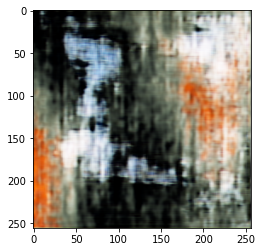

In [377]:
plt.imshow(np.transpose(gen(torch.FloatTensor( np.random.normal(0, 1, (1, 64) )).to(device)).cpu().detach().numpy().reshape(3,256,256), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


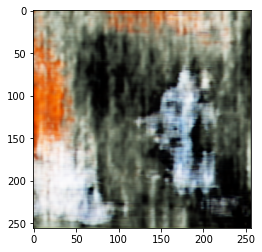

In [404]:
plt.imshow(np.transpose(gen(torch.FloatTensor( np.random.normal(0, 1, (1, 64) )).to(device)).cpu().detach().numpy().reshape(3,256,256), (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


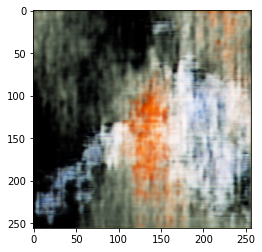

In [483]:
plt.imshow(np.transpose(gen(torch.FloatTensor( np.random.normal(0, 1, (1, 64) )).to(device)).cpu().detach().numpy().reshape(3,256,256), (1,2,0)))

<div class="alert alert-block alert-warning">
<b></b> 
That network need a lot of epochs for normal fitting. Pictures above i create after ~5-10 epochs, because it takes a long time.
</div>